## Setting up

In [41]:
from numpy import (
    pi,linspace, sin, cos, exp, diff, zeros, array, arange,
    ones, inf, sqrt, log2, set_printoptions
)
set_printoptions(linewidth=500)
from numpy.linalg import norm, solve as nsolve
from scipy.interpolate import interp1d
from scipy.linalg import toeplitz
from scipy.sparse import diags as spdiags
from scipy.sparse.linalg import spsolve
from scipy.fftpack import fft, ifft

%matplotlib inline

from matplotlib.style import use
use("seaborn")

from pltconfig import *

# Problem 1

First try with finite differences to get a sense of what the solution will look like.

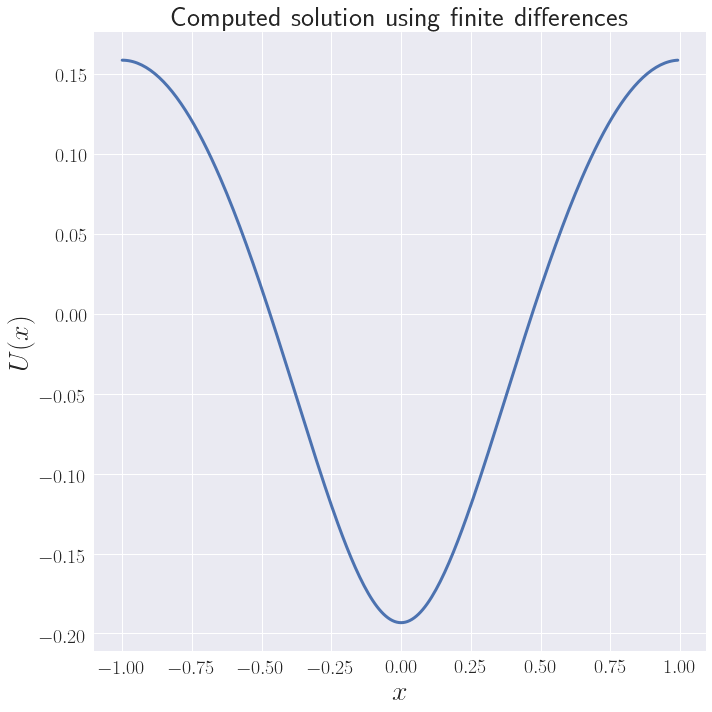

In [42]:
L0 = 2
N = 256
h0 = L0/N
h0_sq = h0*h0
a = -1.0
b = 1.0
L = b-a
h = L/N
h_sq = h*h
scale = L/L0

xj = linspace(a, b-h, N)
yj = (xj-a)/scale

D2 = spdiags(
    array([1, -2, 1])[:,None]*ones(N)[None,:], 
    array([-1,0,1]), 
    (N,N)
    ).tolil() # set matrix up to be modified
# Note: this matrix is singular (solution is specified only up to an
# additive constant), so fix one of the values, say Ufd(1), which is
# equivalent to replacing the first row of D2 with [1, 0, 0, ..., 0];
# translate later to have zero mean.
D2[0,:] = 0.0
D2[0,0] = 1.0
D2[0,-1] = 1.0

# define the RHS matrix
A = ((1./h0_sq)*D2).tocsr() # ensure that it is efficient for computation

fj = 5./(3.0+2.0*cos(pi*yj))
fj -= fj.mean()

# solve linear equation
Ufd = spsolve(A, fj)
# shift to give mean zero
Ufd -= Ufd.mean()

fig, ax = subplots(1,1, figsize=(10,10))

ax.plot(xj, Ufd, lw=3.0)

ax.set_title(
    f"Computed solution using finite differences",
    fontsize=28
    )
ax.tick_params(labelsize=20)
ax.set_ylabel(r"$U(x)$", fontsize=28)
ax.set_xlabel(r"$x$", fontsize=28)

fig.tight_layout()

## Part A

In [43]:
class q1a(object):
    
    def __init__(self, a=-1.0, b=1.0, N=256, use_fft=True):
        
        # unload all the variables
        self.a = a
        self.b = b
        self.N = N
        self.L0 = 2.0
        
        # calculate derived variables
        self.h0 = self.L0/self.N
        self.L = b-a
        self.h = self.L/self.N
        self.scale = self.L/self.L0        
        
        # load arrays
        self.yj = linspace(0.0, self.L0-self.h0, self.N)-(self.L0*0.5)
        self.xj = linspace(self.a, self.b-self.h, self.N)
        self.kM = (array([arange(self.N//2), arange(-self.N//2,0)])*(2*pi/self.L0)).flatten()
        self.kMd = zeros(self.N)
        self.kMd[...] = self.kM[...]; self.kMd[0] = 1 # avoid division by zero
        
        # define the right hand side
        self.F = self.get_rhs()
        
        self.A = None
        
        # get the solution
        if not use_fft:
            # get the differentiation matrix
            self.A = self.get_A()
            self.U = self.get_soln()
        else:
            self.U = self.get_fft_soln()
            
        self.soln_interp = interp1d(self.xj, self.U, kind="cubic")
        
    def get_rhs(self):
        
        y = self.yj
        
        fj = 5/(3+2*cos(pi*y))
        
        return fj - fj.mean()
    
    def get_A(self):
        
        N = self.N
        L = self.L0
        h = self.h0; h_sq = h*h
        
        # construct 2nd order differentiation matrix
        jj = arange(1,N)
        column = zeros(N)
        column[0] = -((pi**2)/(3*h_sq)+(1./6))
        column[1:] = -0.5*((-1)**jj)/(sin(h*0.5*jj)**2)

        DN2 = ((2*pi/L)**2)*toeplitz(column)
        # again this matrix is singular
        DN2[0,:] = 0.0
        DN2[0,0] = 1.0
        
        return DN2
    
    def get_soln(self):
        u = nsolve(self.A, self.F)
        return u - u.mean() 
    
    def get_fft_soln(self):
        fj = self.F
        
        kMd = self.kMd
        
        fk = fft(fj)
        fk[0] = 0.0+0.0j # fix mean 0, just playing safe
        
        Uk = -fk/(kMd**2)
        Uj = ifft(Uk)
        
        return Uj.real
    
    def get_plot(self):
        
        fig, ax = subplots(1,1, figsize=(10,10))

        ax.plot(self.yj+self.a, self.U.T, lw=3.0)

        ax.set_title(
            f"Computed solution",
            fontsize=20
            )
        ax.tick_params(labelsize=20)
        ax.set_ylabel(r"$U(x)$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)

        fig.tight_layout()

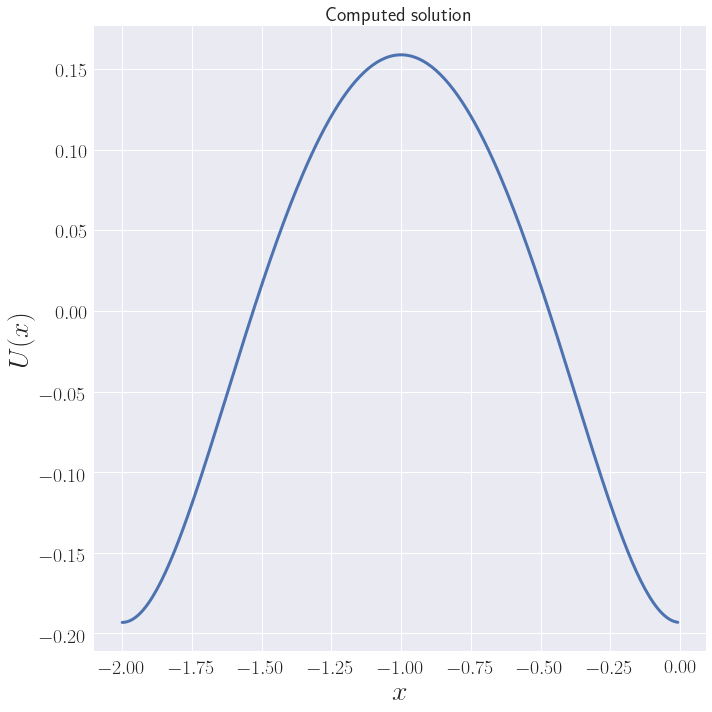

In [44]:
sample_q1a = q1a()
sample_q1a.get_plot()

In [45]:
sample_q1a.soln_interp(0.5)

array(0.01596073)

This looks exactly like the computed solution from the explicit finite difference method so looks like we're good.

In [46]:
def q1a_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        hvals = zeros(n)
        Nvals = zeros(n)
        pt_error_array_norm = zeros(n)
        error_array_infnorm = zeros(n)

        # set the number of initial number of internal points
        N_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q1a(N=N_coarse)

        print(f"N      h        x=0.5 error  inf-norm error  ratio (inf-norm)  order (inf-norm)")
        
        for i in range(n):

            # define the finer grids
            N_fine = 2*N_coarse

            # construct the meshes and solve 
            soln_fine = q1a(N=N_fine)

            # compute the errors using the grid-2norm
            pt_error_array_norm[i] = (soln_coarse.soln_interp(0.5)-soln_fine.soln_interp(0.5)).__abs__()

            # compute the errors using the infinity-norm
            error_array_infnorm[i] = norm((soln_coarse.U-soln_fine.U[::2]).flatten(), ord=inf)

            # record the spacing
            hvals[i] = soln_coarse.h
            Nvals[i] = N_coarse
            
            if (i > 0):
                print(
                    f"{N_coarse:<7d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{pt_error_array_norm[i]:<13.2e}"
                    + f"{error_array_infnorm[i]:<16.2e}"
                    + f"{error_array_infnorm[i]/error_array_infnorm[i-1]:<18.5f}"
                    + f"{-log2((error_array_infnorm[i]/error_array_infnorm[i-1]).__abs__()):<16.5f}"
                    )
            else:
                print(
                    f"{N_coarse:<7d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{pt_error_array_norm[i]:<13.2e}"
                    + f"{error_array_infnorm[i]:<16.2e}"
                    )
                
            # set the current fine grid as the coarse grid for next iteration
            N_coarse = N_fine 
            soln_coarse = soln_fine

        return Nvals, hvals, pt_error_array_norm, error_array_infnorm

In [47]:
def plot_1a():
    
    Nvals, hvals, error_array_2norm, error_array_infnorm = q1a_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(Nvals, 1./(10*Nvals*Nvals), lw=3.0, ls="--", color="gray", label=r"reference $N^{-2}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q1a_fig.pdf")

N      h        x=0.5 error  inf-norm error  ratio (inf-norm)  order (inf-norm)
4      0.50000  6.03e-04     2.63e-02        
8      0.25000  3.23e-04     1.18e-03        0.04489           4.47730         
16     0.12500  4.49e-07     2.38e-06        0.00202           8.95407         
32     0.06250  2.04e-11     9.68e-11        0.00004           14.58870        
64     0.03125  3.47e-18     0.00e+00        0.00000           inf             
128    0.01562  0.00e+00     2.78e-17        inf               -inf            
256    0.00781  0.00e+00     2.78e-17        1.00000           -0.00000        
512    0.00391  0.00e+00     2.78e-17        1.00000           -0.00000        
1024   0.00195  0.00e+00     2.78e-17        1.00000           -0.00000        


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


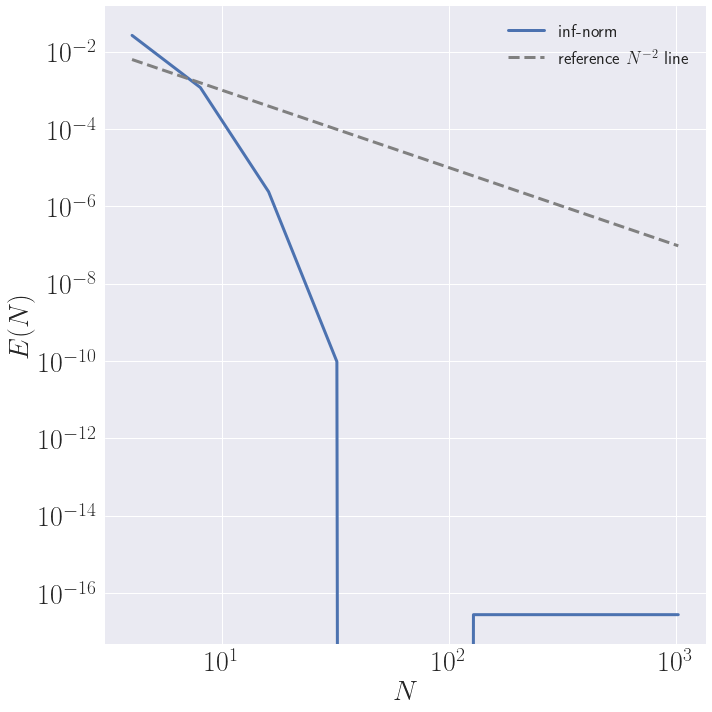

In [48]:
plot_1a()

## Part B

In [49]:
class q1b(q1a):
    
    def __init__(self, a=-1.0, b=1.0, N=256, use_fft=True):
        
        # unload all the variables
        self.a = a
        self.b = b
        self.N = N
        self.L0 = 2.0
        
        # calculate derived variables
        self.h0 = self.L0/self.N
        self.L = b-a
        self.h = self.L/self.N
        self.scale = self.L/self.L0        
        
        # load arrays
        self.xj = linspace(self.a, self.b-self.h, self.N)
        self.yj = linspace(0.0, self.L0-self.h0, self.N)+self.a
        self.kM = (array([arange(self.N//2), arange(-self.N//2,0)])*(2*pi/self.L0)).flatten()
        self.kMd = zeros(self.N)
        self.kMd[...] = self.kM[...]; self.kMd[0] = 1 # avoid division by zero
        
        # define the right hand side
        self.F = self.get_rhs()
        
        self.A = None
        
        # get the solution
        if not use_fft:
            # get the differentiation matrix
            self.A = self.get_A()
            self.U = self.get_soln()
        else:
            self.U = self.get_fft_soln()
            
        self.soln_interp = interp1d(self.xj, self.U, kind="cubic")
        
    def get_rhs(self):
        
        y = self.yj
        
        fj = sin(1.5*pi*y)
        
        return fj

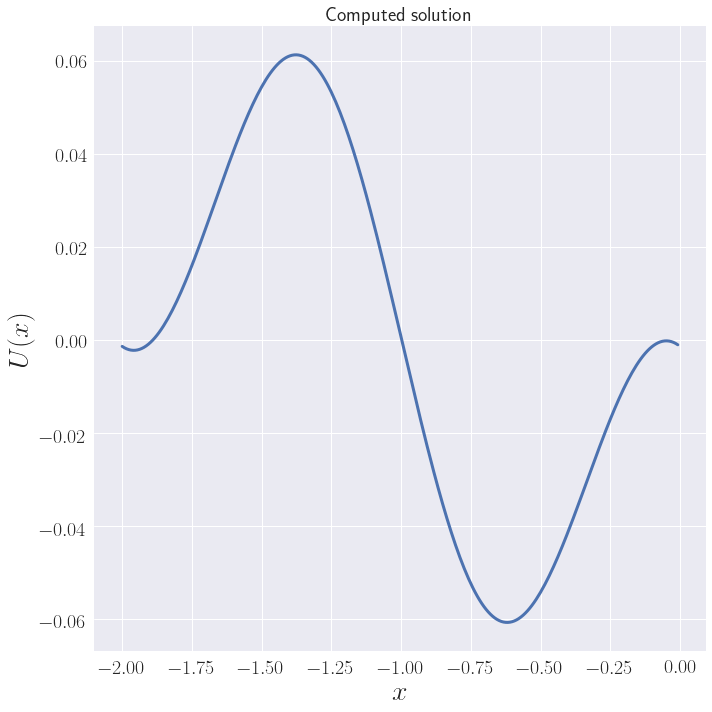

In [50]:
sample_q1b = q1b()
sample_q1b.get_plot()

In [51]:
def q1b_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        hvals = zeros(n)
        Nvals = zeros(n)
        pt_value = zeros(n)
        pt_error_array_norm = zeros(n)
        error_array_infnorm = zeros(n)

        # set the number of initial number of internal points
        N_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q1b(N=N_coarse)

        print(f"N      h        x=0.5 value    x=0.5 error  inf-norm error  ratio (inf-norm)  order (inf-norm)")
        
        for i in range(n):

            # define the finer grids
            N_fine = 2*N_coarse

            # construct the meshes and solve 
            soln_fine = q1b(N=N_fine)
            
            pt_value[i] = soln_coarse.soln_interp(0.5)

            # compute the errors using the grid-2norm
            pt_error_array_norm[i] = (soln_coarse.soln_interp(0.5)-soln_fine.soln_interp(0.5)).__abs__()

            # compute the errors using the infinity-norm
            error_array_infnorm[i] = norm((soln_coarse.U-soln_fine.U[::2]).flatten(), ord=inf)

            # record the spacing
            hvals[i] = soln_coarse.h
            Nvals[i] = N_coarse
            
            if (i > 0):
                print(
                    f"{N_coarse:<7d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{pt_value[i]:<15.2e}"
                    + f"{pt_error_array_norm[i]:<13.2e}"
                    + f"{error_array_infnorm[i]:<16.2e}"
                    + f"{error_array_infnorm[i]/error_array_infnorm[i-1]:<18.5f}"
                    + f"{-log2((error_array_infnorm[i]/error_array_infnorm[i-1]).__abs__()):<16.5f}"
                    )
            else:
                print(
                    f"{N_coarse:<7d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{pt_value[i]:<15.2e}"
                    + f"{pt_error_array_norm[i]:<13.2e}"
                    + f"{error_array_infnorm[i]:<16.2e}"
                    )
                
            # set the current fine grid as the coarse grid for next iteration
            N_coarse = N_fine 
            soln_coarse = soln_fine

        return Nvals, hvals, pt_value, pt_error_array_norm, error_array_infnorm

In [52]:
def plot_1b():
    
    Nvals, hvals, pt_value, error_array_2norm, error_array_infnorm = q1b_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(Nvals, 1./(Nvals), lw=3.0, ls="--", color="gray", label=r"reference $N^{-1}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q1b_fig.pdf")

N      h        x=0.5 value    x=0.5 error  inf-norm error  ratio (inf-norm)  order (inf-norm)
4      0.50000  -6.53e-02      1.38e-02     2.33e-02        
8      0.25000  -5.15e-02      8.94e-04     1.60e-02        0.68746           0.54066         
16     0.12500  -5.24e-02      8.29e-04     9.23e-03        0.57577           0.79644         
32     0.06250  -5.32e-02      5.30e-04     4.91e-03        0.53236           0.90953         
64     0.03125  -5.37e-02      2.95e-04     2.53e-03        0.51513           0.95699         
128    0.01562  -5.40e-02      1.55e-04     1.28e-03        0.50734           0.97899         
256    0.00781  -5.42e-02      7.95e-05     6.46e-04        0.50361           0.98961         
512    0.00391  -5.43e-02      4.02e-05     3.24e-04        0.50179           0.99483         
1024   0.00195  -5.43e-02      2.02e-05     1.62e-04        0.50089           0.99742         


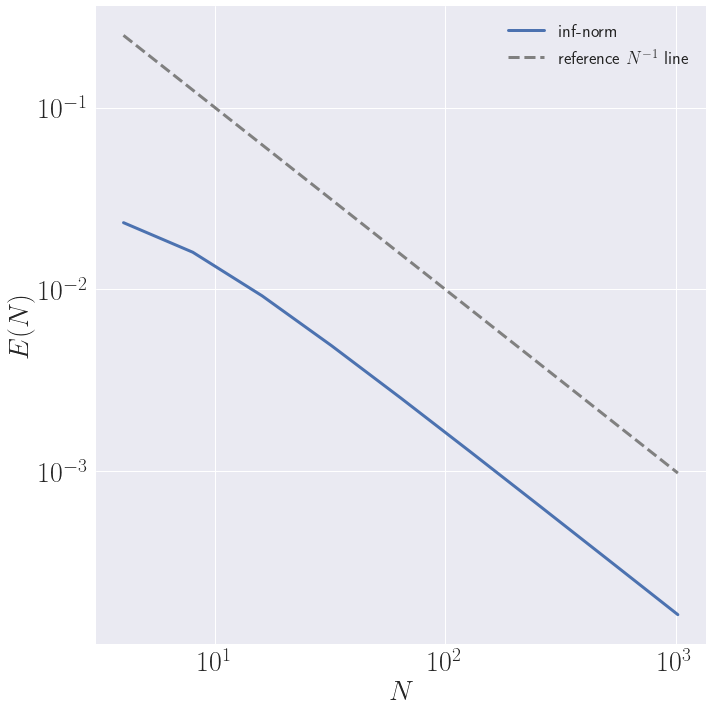

In [53]:
plot_1b()